In [1]:
import pandas as pd
import geopandas as gpd
from configparser import RawConfigParser
import matplotlib.pyplot as plt
import numpy as np
import os, sys

In [2]:
if gpd.__version__ < '0.7.0':
    sys.exit('please upgrade geopandas to version 0.7.0, your current version is {}'.format(gpd.__version__))

In [3]:
settings_file = 'run_setting.cfg'

In [4]:
config = RawConfigParser(allow_no_value=True)
config.read(settings_file);

### Trying to fix clipping KG to continent

In [5]:
Koeppen_Geiger_fo = os.path.join(config.get('general', 'input_dir'),
                                 config.get('climate', 'shp')) 

In [6]:
KG_gdf = gpd.read_file(Koeppen_Geiger_fo)
KG_gdf.head()

,ID,GRIDCODE,geometry
0,1,62,"POLYGON ((-37.50000 83.50000, -38.00000 83.500..."
1,2,62,"POLYGON ((-29.50000 83.50000, -37.00000 83.500..."
2,3,62,"POLYGON ((-46.00000 83.00000, -46.00000 83.500..."
3,4,62,"POLYGON ((-42.50000 83.50000, -39.50000 83.500..."
4,5,61,"POLYGON ((55.50000 81.00000, 55.50000 81.50000..."


In [7]:
code2class_fo = os.path.join(config.get('general', 'input_dir'), 
                             config.get('climate', 'code2class'))
code2class = pd.read_csv(code2class_fo, sep='\t')

In [8]:
look_up_classes = config.get('climate', 'zones').rsplit(',')
look_up_classes

['BWh', 'BSh']

In [9]:
code_nrs = []
for entry in look_up_classes:
    code_nr = int(code2class['code'].loc[code2class['class'] == entry])
    print(entry, '-->', code_nr)
    code_nrs.append(code_nr)

BWh --> 22
BSh --> 27


In [10]:
KG_gdf_sel = KG_gdf.loc[KG_gdf['GRIDCODE'].isin(code_nrs)]

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
continent_gdf = world[world["continent"] == config.get('settings', 'continent')]

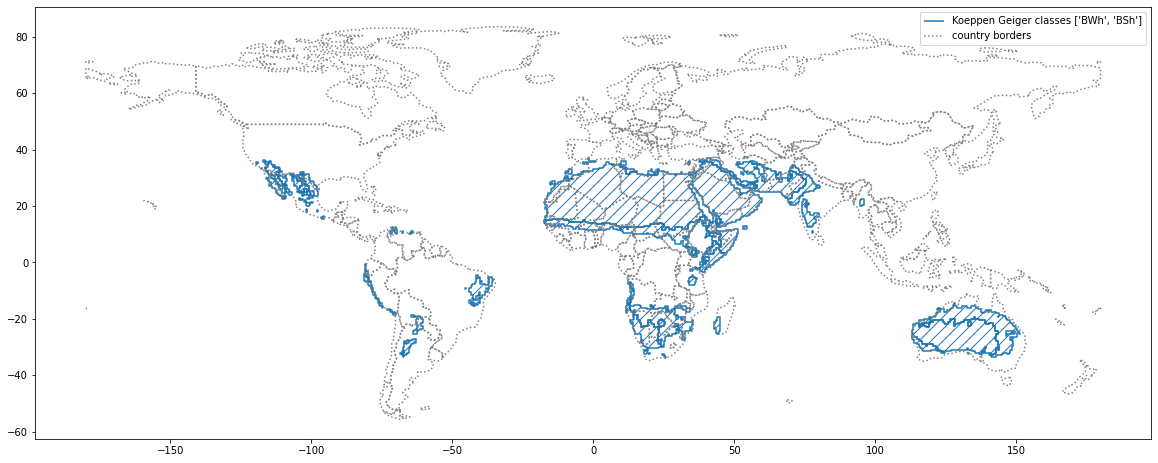

In [12]:
ax = KG_gdf_sel.boundary.plot(figsize=(20,10),
                              hatch="//",
                              label='Koeppen Geiger classes ' + str(look_up_classes))

world.boundary.plot(ax=ax, 
                          color='0.5', 
                          linestyle=':',
                          label='country borders')

plt.legend()

In [13]:
KG_gdf_sel = gpd.clip(KG_gdf_sel.buffer(0), continent_gdf)

C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


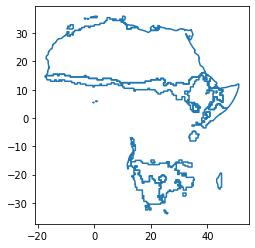

In [15]:
KG_gdf_sel.boundary.plot()

# Functions

In [16]:
def pd_to_gpd_dataframe(df, longitude='longitude', latitude='latitude', crs='EPSG:4326'):
    
    print('...translating to geopandas dataframe')
    
    df = gpd.GeoDataFrame(df,
                          geometry=gpd.points_from_xy(df[longitude], df[latitude]),
                          crs=crs)
    
    return df

In [17]:
def select_period(gdf, config):
    
    t0 = config.getint('settings', 'y_start')
    t1 = config.getint('settings', 'y_end')
    
    print('')
    print('focussing on period between', t0, 'and', t1)
    
    gdf = gdf.loc[(gdf.year >= t0) & (gdf.year <= t1)]
    
    return gdf

In [18]:
def clip_to_continent(gdf, config):
    
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    continent_gdf = world[world["continent"] == config.get('settings', 'continent')]
    
    print('')
    print('clipping dataset to continent', str(config.get('settings', 'continent')))
    
    gdf = gpd.clip(gdf, continent_gdf)
    
    return gdf, continent_gdf

In [19]:
def climate_zoning(gdf, config):
    
    Koeppen_Geiger_fo = os.path.join(config.get('general', 'input_dir'),
                                     config.get('climate', 'shp')) 
    
    code2class_fo = os.path.join(config.get('general', 'input_dir'),
                                 config.get('climate', 'code2class'))
    
    look_up_classes = config.get('climate', 'zones').rsplit(',')
    
    KG_gdf = gpd.read_file(Koeppen_Geiger_fo)
    code2class = pd.read_csv(code2class_fo, sep='\t')
    
    code_nrs = []
    for entry in look_up_classes:
        code_nr = int(code2class['code'].loc[code2class['class'] == entry])
        code_nrs.append(code_nr)
    
    print('')
    print('reducing to climate zones')
    KG_gdf = KG_gdf.loc[KG_gdf['GRIDCODE'].isin(code_nrs)]
    
    if KG_gdf.crs != gdf.crs:
        print('...CRS needs to be aligned')
        KG_gdf = KG_gdf.to_crs(gdf.crs)

    gdf = gpd.clip(gdf, KG_gdf.buffer(0))
    
    return gdf

In [20]:
def filter_conflicts(config, plot_bnds=False):
    
    conflict_fo = os.path.join(config.get('general', 'input_dir'), 
                               config.get('conflict', 'conflict_file'))
    
    print('reading csv file to dataframe...' + os.linesep)
    df = pd.read_csv(conflict_fo)
    
    selection_criteria = {'best': config.getint('conflict', 'min_nr_casualties'),
                          'type_of_violence': config.getint('conflict', 'type_of_conflict'),
                          'country': config.get('conflict', 'country')}
    
    print('filtering conflict database...' + os.linesep)
    
    for key in selection_criteria:

        if selection_criteria[key] == '':
            print('...passing key', key, 'as it is empty')
            pass

        elif isinstance(selection_criteria[key], (int)):
            if key == 'type_of_violence':
                print('...filtering key', key, 'with value', selection_criteria[key])
                df = df.loc[(df[key] == selection_criteria[key])]
            else:
                print('...filtering key', key, 'with lower value', selection_criteria[key])
                df = df.loc[(df[key] >= selection_criteria[key])]

        elif (isinstance(selection_criteria[key], (str))):
            print('...filtering key', key, 'with value', selection_criteria[key])
            df = df.loc[(df[key] == selection_criteria[key])]

    gdf = pd_to_gpd_dataframe(df)
    
    gdf = select_period(gdf, config)

    continent_conflict_gdf, continent_gdf = clip_to_continent(gdf, config)
    
    continent_conflict_gdf = climate_zoning(continent_conflict_gdf, config)
    
    if plot_bnds:
        print('')
        print('plotting result')
        ax = continent_conflict_gdf.plot(figsize=(10,5), legend=True, label='PRIO/UCDP events')
        continent_gdf.boundary.plot(ax=ax, color='0.5', linestyle=':')
        plt.legend()
        ax.set_xlim(continent_gdf.total_bounds[0]-1, continent_gdf.total_bounds[2]+1)
        ax.set_ylim(continent_gdf.total_bounds[1]-1, continent_gdf.total_bounds[3]+1)
    
    return continent_conflict_gdf, continent_gdf

# Applying functions

reading csv file to dataframe...

filtering conflict database...

...filtering key best with lower value 5
...filtering key type_of_violence with value 1
...passing key country as it is empty
...translating to geopandas dataframe

focussing on period between 2000 and 2005

clipping dataset to continent Africa

reducing to climate zones
...CRS needs to be aligned

plotting result


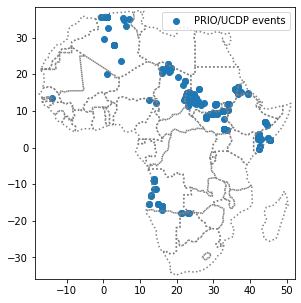

In [21]:
continent_conflict_gdf, continent_gdf = filter_conflicts(config, plot_bnds=True)

In [22]:
continent_conflict_gdf.head()

,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,gwnoa,...,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,low,best,high,geometry
760,8202,2000,1,1,309,Sudan: Government,663,Government of Sudan - SPLM/A,112,625.0,...,2000-06-18,2000-06-21,430,0,0,0,430,430,430,POINT (32.70000 10.00000)
836,8723,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,2004-01-16,2004-01-19,560,100,0,0,660,660,660,POINT (22.80000 15.00000)
839,8168,2004,1,1,309,Sudan: Government,666,Government of Sudan - SLM/A,112,625.0,...,2004-11-21,2004-11-23,30,0,7,0,37,37,37,POINT (24.90000 13.50000)
1324,33456,2000,1,1,409,Eritrea - Ethiopia,865,Government of Eritrea - Government of Ethiopia,98,531.0,...,2000-05-23,2000-05-25,24,0,0,0,24,24,24,POINT (39.38500 14.52194)
1326,34440,2000,1,1,409,Eritrea - Ethiopia,865,Government of Eritrea - Government of Ethiopia,98,531.0,...,2000-06-05,2000-06-06,700,0,0,0,700,700,700,POINT (36.65750 15.11000)


# Analysis per year

In [23]:
continent_conflict_gdf.columns

Index(['id', 'year', 'active_year', 'type_of_violence', 'conflict_new_id',
       'conflict_name', 'dyad_new_id', 'dyad_name', 'side_a_new_id', 'gwnoa',
       'side_a', 'side_b_new_id', 'gwnob', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates', 'adm_1', 'adm_2',
       'latitude', 'longitude', 'geom_wkt', 'priogrid_gid', 'country',
       'country_id', 'region', 'event_clarity', 'date_prec', 'date_start',
       'date_end', 'deaths_a', 'deaths_b', 'deaths_civilians',
       'deaths_unknown', 'low', 'best', 'high', 'geometry'],
      dtype='object')

In [107]:
def conflict_in_year_bool(gdf, continent_gdf, config, plotting=False):
    
    years = gdf.year.unique()

    for year in np.sort(years):
        print(year)
        temp_sel_year = gdf.loc[gdf.year == year]
        
        data_merged = gpd.sjoin(temp_sel_year, continent_gdf, how="inner", op='within')
        
        provinces_annual_sum = pd.merge(continent_gdf,
                                        data_merged['best'].groupby(data_merged['name']).sum().\
                                        to_frame().rename(columns={"best": "best_SUM"}),
                                        on='name')
        
        provinces_annual_sum['conflict_bool'] = np.where(provinces_annual_sum['best_SUM']>0.0, 1, 0)
            
        if plotting:
            
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10), sharey=True)
    
            provinces_annual_sum.plot(ax=ax1,column='conflict_bool',
                                           vmin=0,
                                           vmax=2,
                                           categorical=True,
                                           legend=True)

            continent_gdf.boundary.plot(ax=ax1,
                                        color='0.5',
                                        linestyle=':')

            ax1.set_xlim(continent_gdf.total_bounds[0]-1, continent_gdf.total_bounds[2]+1)
            ax1.set_ylim(continent_gdf.total_bounds[1]-1, continent_gdf.total_bounds[3]+1)
            
            provinces_annual_sum.plot(ax=ax2, column='best_SUM',
                                           vmin=0,
                                           vmax=1500)

            continent_gdf.boundary.plot(ax=ax2,
                                        color='0.5',
                                        linestyle=':')

            ax2.set_xlim(continent_gdf.total_bounds[0]-1, continent_gdf.total_bounds[2]+1)
            ax2.set_ylim(continent_gdf.total_bounds[1]-1, continent_gdf.total_bounds[3]+1)
    
    print('end of loop')
    
    return provinces_annual_sum

2000
2001
2002
2003
2004
2005
end of loop


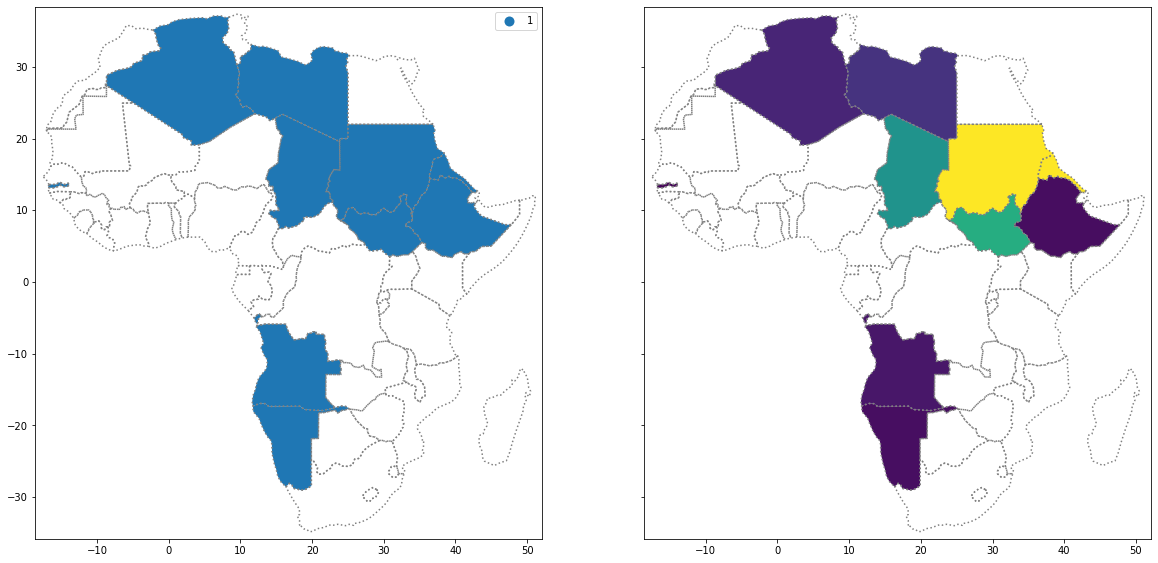

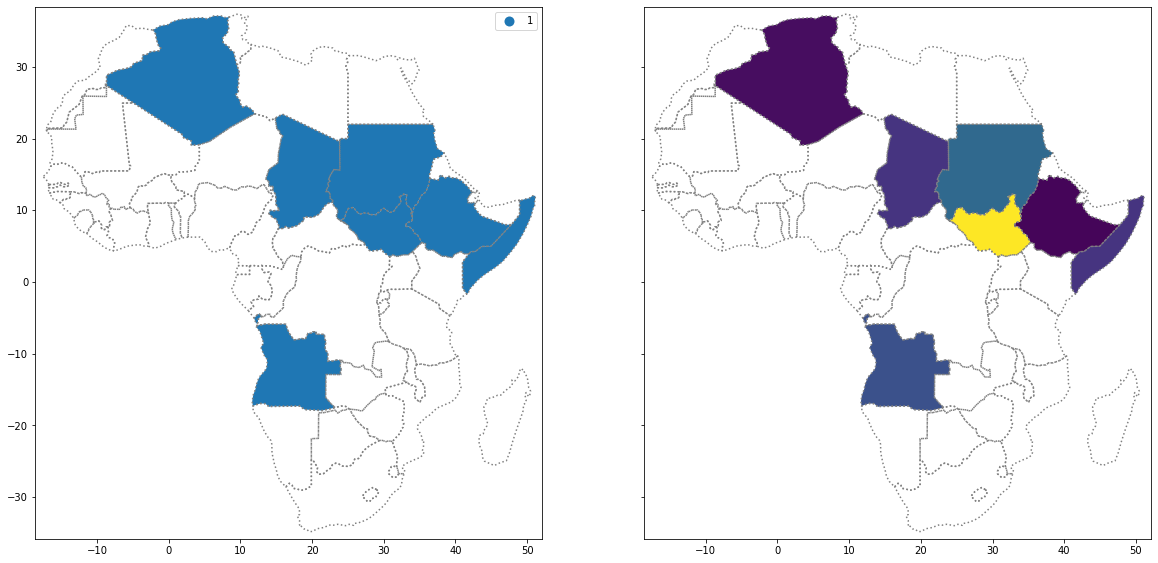

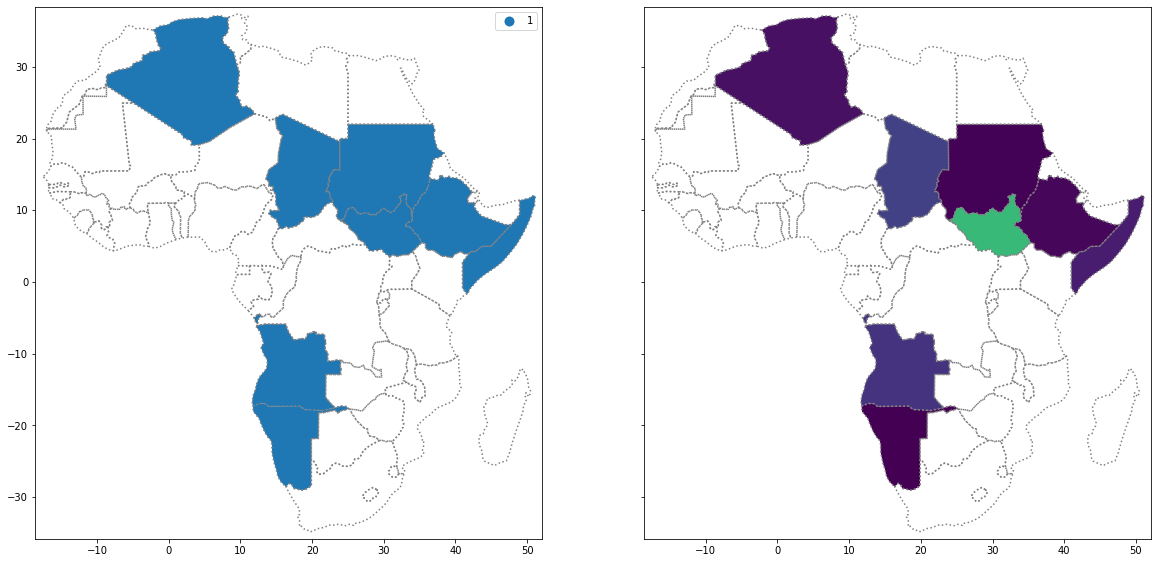

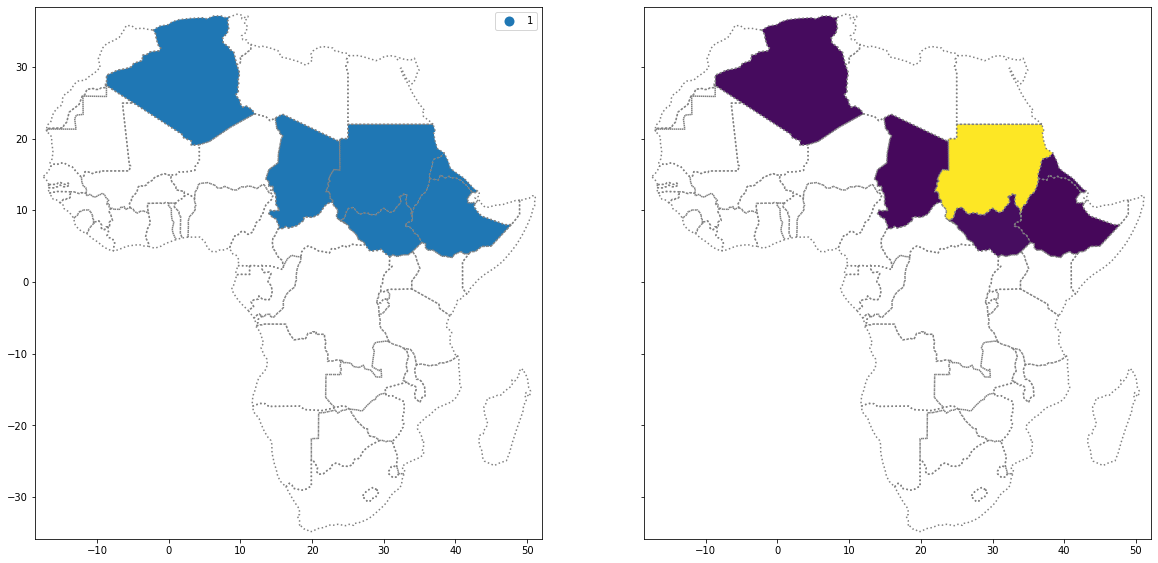

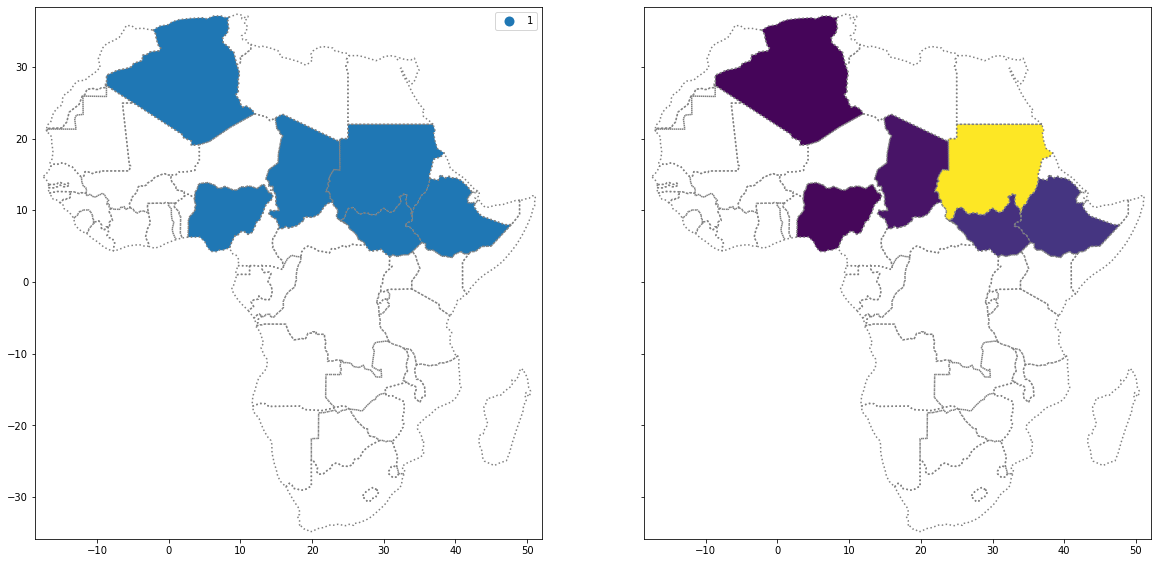

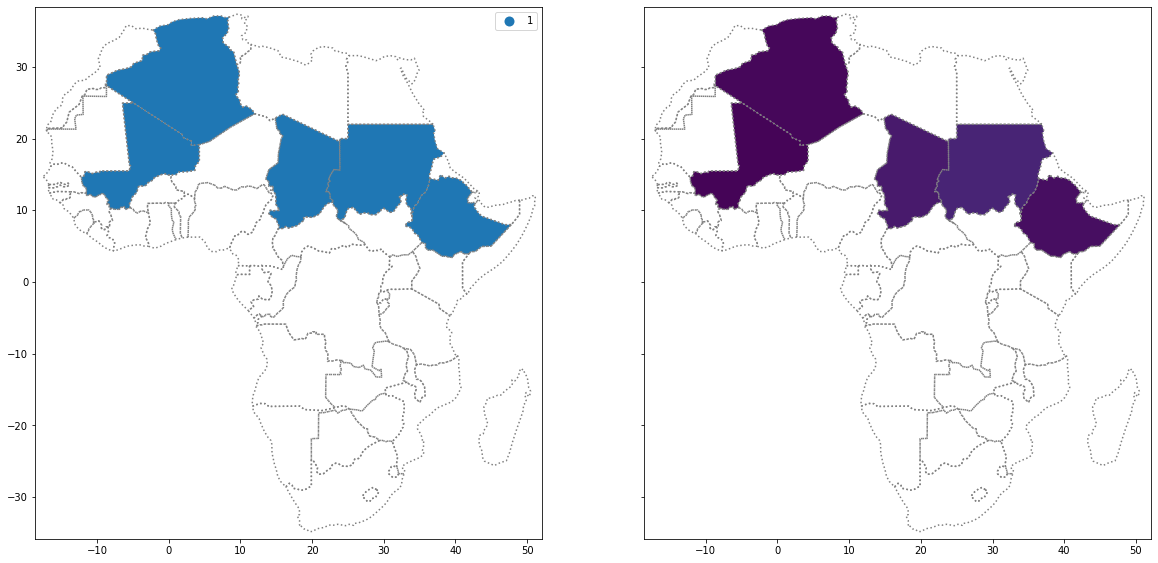

In [108]:
test = conflict_in_year_bool(continent_conflict_gdf, continent_gdf, config, plotting=True)
# temp_sel.head()